In [2]:
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.backends.cudnn.enabled = True#cuda提供的加速

In [3]:
import torchvision
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader
#画图,辅助
import matplotlib.pyplot as plt
from time import time
import random
import numpy as np
import pandas
import datetime
import gc
#设置全局随机数种子
torch.manual_seed(112)
random.seed(112)
np.random.seed(112)

In [4]:
#GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### 数据预处理

In [6]:
print(os.path.exists("/data_disk/dyy/python_projects/bili_dif/data_SVHN"))

#定义一些数据增强的Compose
trainT=T.Compose([
    T.RandomCrop(28),#裁剪尺寸
    T.RandomRotation(degrees=[-30,30]),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
]
)
testT=T.Compose([
    T.CenterCrop(28),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])   
])

train=torchvision.datasets.SVHN(
    root='/data_disk/dyy/python_projects/bili_dif/data_SVHN',
    split='train',
    download=False,
    transform=trainT
)
test=torchvision.datasets.SVHN(
    root='/data_disk/dyy/python_projects/bili_dif/data_SVHN',
    split='test',
    download=False,
    transform=testT
)
print(train.data.shape)
print(type(train))


True
(73257, 3, 32, 32)
<class 'torchvision.datasets.svhn.SVHN'>


In [211]:
#train[2][1]#第一个索引表示第几个样本,每个样本有两个元素,第一个是图像,第二个是标签
np.unique(train.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [212]:
#随机抽(图,标签)的工具函数
def plotsample(data):#只能接受Tensor格式
    fig,axs=plt.subplots(1,5,figsize=(10,10))
    for i in range(5):
        num=random.randint(0,len(data)-1)#roll五个数
        npimg=torchvision.utils.make_grid(data[num][0]).numpy()#make_grid提升通道数
        nplabel=data[num][1]#标签提出来
        axs[i].imshow(np.transpose(npimg,(1,2,0)))
        axs[i].set_title(nplabel)
        axs[i].axis('off') 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.2870589].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.33934647].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.7925056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.7925056].


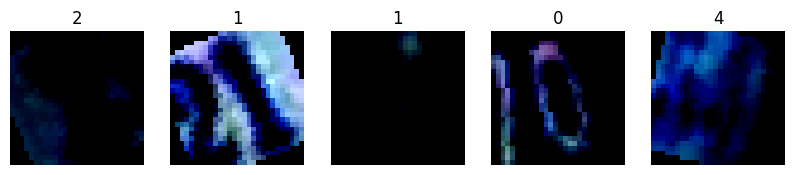

In [213]:
#需要注意的是,
# 如果是归一化后的图像,本质上来讲,让它显示出来是没什么意义的,
# 因为PIL图像期待像素在[0,255]之间,归一化后必然导致图像失真
plotsample(train)

#### 模型选择 此处选择ResNet和Vgg

In [214]:
torch.manual_seed(112)
resnet18_=m.resnet18()
vgg16_=m.vgg16()

In [215]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3
                                              ,stride=1,padding=1,bias=False)
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) #删除池化层
        
        #后续的架构直接从经典架构中选
        #对尺寸很小的数据集而言，我们的深度本来就不深，因此可以试着在特征图数量上有所增加（增加宽度）
        self.block2 = resnet18_.layer2 #2个残差单元
        self.block3 = resnet18_.layer3 #2个残差单元
        #自适应平均池化+线性层，此处都与残差网络一致
        self.avgpool = resnet18_.avgpool
        #输出的线性层自己写，以确保输出的类别数量正确
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = self.fc(x)
        return x

In [216]:
model=MyResNet()

In [217]:
class MyVgg(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features=nn.Sequential(
            *vgg16_.features[0:9],#这里解包表示这个东西从Sequential中取出来
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2,padding=0,dilation=1,ceil_mode=True)
        )
        self.avgpool=vgg16_.avgpool
        self.fc=nn.Sequential(
            nn.Linear(7*7*128,out_features=4096,bias=True),
            *vgg16_.classifier[1:6],
            nn.Linear(in_features=4096,out_features=10,bias=True)
        )
    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x=x.view(x.shape[0],7*7*128)
        x=self.fc(x)
        return x

In [218]:
#单元测试
from torchinfo import summary
print(summary(MyResNet(),(10,3,28,28),depth=1,device=device))
summary(MyVgg(),(10,3,28,28),depth=1,device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MyResNet                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 64, 28, 28]          1,856
├─Sequential: 1-2                        [10, 128, 14, 14]         525,568
├─Sequential: 1-3                        [10, 256, 7, 7]           2,099,712
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]                  2,570
Total params: 2,629,706
Trainable params: 2,629,706
Non-trainable params: 0
Total mult-adds (G): 2.07
Input size (MB): 0.09
Forward/backward pass size (MB): 38.13
Params size (MB): 10.52
Estimated Total Size (MB): 48.75


Layer (type:depth-idx)                   Output Shape              Param #
MyVgg                                    [10, 10]                  --
├─Sequential: 1-1                        [10, 128, 7, 7]           555,328
├─AdaptiveAvgPool2d: 1-2                 [10, 128, 7, 7]           --
├─Sequential: 1-3                        [10, 10]                  42,516,490
Total params: 43,071,818
Trainable params: 43,071,818
Non-trainable params: 0
Total mult-adds (G): 1.74
Input size (MB): 0.09
Forward/backward pass size (MB): 16.71
Params size (MB): 172.29
Estimated Total Size (MB): 189.09

### 提前停止

In [219]:
class EarlyStopping():
    def __init__(self, patience=20, tolerance=0.0005):
        self.patience = patience
        self.tolerance=tolerance
        self.counter=0#用来计数,判断当前是否已经累计patience次了
        self.lowest_loss=None#历史最低损失
        self.early_stop=False#True-提前结束，False-继续训练
    
    def __call__(self, val_loss):#val_loss当前Epoch损失
        if self.lowest_loss is None:#第一次进来
            self.lowest_loss=val_loss
        elif self.lowest_loss-val_loss>self.tolerance:#如果比当前损失小,则替换最小值
            self.lowest_loss=val_loss
            self.counter=0
        elif self.lowest_loss-val_loss<self.tolerance:#小于阈值,说明在最低损失的附近
            self.counter+=1
            print('Attention!! EarlyStopping counter: {} out of {}'.format(self.counter,self.patience))
            if self.counter>=self.patience:#如果累计了patience次，则提前结束 
                print('Early Stop Activate!')
                self.early_stop=True
        return self.early_stop

### 训练函数

In [220]:
#把单词训练和测试的提取出来,fit_test()中只放一些有关数据等的记录
def IterOnce(net, criterion, optimizer, x, y):
    # 添加输入形状检查
    if len(x.shape) != 4:
        raise ValueError(f"Expected 4D input, but got shape {x.shape}")
    sigma = net.forward(x)
    loss = criterion(sigma, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    yhat = torch.max(sigma, 1)[1]
    correct = torch.sum(yhat == y)
    return correct, loss

def TestOnce(net,criterion,x,y):
    with torch.no_grad():
        sigma=net.forward(x)
        loss=criterion(sigma,y)
        yhat=torch.max(sigma,1)[1]
        correct=torch.sum(yhat==y)
    return correct,loss


In [221]:
def fit_test(net,batchdata,testdata,criterion,optimizer,epochs,tolerance):
    '''
    对模型进行训练,并在每个epoch后输出训练集和测试集上的准确率--对模型的监控
    保存模型
    '''
    SamplePerEpoch=batchdata.dataset.__len__()
    allSamples=SamplePerEpoch*epochs
    trainedSamples=0
    trainLossList=[]
    testLossList=[]#这两个list是用来画图的
    early_stopping=EarlyStopping(tolerance=tolerance)
    highestAcc=None
    save_path='/data_disk/dyy/python_projects/bili_dif/learn/5.小型项目/state_dict'

    #还得来个epoch
    for epoch in range(1,1+epochs):
        net.train()
        correct_train=0
        loss_train=0
        for batch_idx,(x,y) in enumerate(batchdata):
            x=x.to(device,non_blocking=True)
            y=y.to(device,non_blocking=True).view(x.shape[0])#有的标签是列向量,需要转化为一维的张量
            '''
                #这时还没有经过softmax,其中的最大值就可以视为 y_hat,
                考虑此时yhat的形状是什么--有Sample个样本,9中分类,那就是Sample*9
                需要将9种分类中取出最大值,作为预测出的分类
            '''
            correct,loss=IterOnce(net,criterion,optimizer,x,y)
            trainedSamples+=x.shape[0]
            loss_train+=loss
            correct_train+=correct#记录当前Epoch总共的正确样本数
            
            if((batch_idx+1)%125==0):
                print('Train Epoch:{} [{}/{} ({:.0f}%)]'.format(
                    epoch,
                    trainedSamples,
                    allSamples,
                    trainedSamples/allSamples*100,
                ))
        

        trainAccThisEpoch=float(correct_train*100)/SamplePerEpoch
        trainLossThisEpoch=float(loss_train*100)/SamplePerEpoch#表示平均每个样本上的损失
        trainLossList.append(trainLossThisEpoch)

        #完成一次epoch后,需要清理GPU内存
        del x,y,loss,correct_train,loss_train#清变量
        gc.collect()#清缓存
        torch.cuda.empty_cache()#


        #这里就测一次,不需要再嵌套一个循环---因此这里的代码要和Epoch内层循环类比
        net.eval()
        loss_test=0
        correct_test=0
        TestSample=testdata.dataset.__len__()

        for x,y in testdata:
            x=x.to(device,non_blocking=True)
            
            y=y.to(device,non_blocking=True).view(x.shape[0])
            correct,loss=TestOnce(net,criterion,x,y)
                #算总loss和correct
            loss_test+=loss
            correct_test+=correct
        testAccThisEpoch=float(correct_test*100)/TestSample
        testLossThisEpoch=float(loss_test*100)/TestSample#平均每一个样本的损失
        testLossList.append(testLossThisEpoch)
        
    
        # del x,y,loss,correct_train,loss_train#清变量
        # gc.collect()#清缓存
        # torch.cuda.empty_cache()#


        #对于每一个Epoch,打印训练和测试的结果
        print('\t Train Loss:{:.6f},Test Loss:{:.6f},Train Acc:{:.2f}%,Test Acc:{:.2f}%'.format(
            trainLossThisEpoch,
            testLossThisEpoch,
            trainAccThisEpoch,
            testAccThisEpoch
        ))




        #如果测试机准确率新高,或者测试机Loss新低,那就保存权重
        if highestAcc is None or testAccThisEpoch>highestAcc:
            highestAcc=testAccThisEpoch
            torch.save(net.state_dict(),os.path.join(save_path,'best.pth'))
            print('Attention:Save Best Model!!!')


        #提前停止
        # early_stop=early_stopping(testLossThisEpoch)
        # if early_stop is True:
        #     print('Early Stopping')
        #     break

    print('Mission Complete!') 
    return trainLossList,testLossList

#### 定义整个执行流中需要的小组件,opt,loss

In [222]:
def full_procedure(net,epochs=100,bs=128,lr=0.001,alpha=0.99,gamma=0,wd=0,tolerance=0.00001):
    torch.cuda.manual_seed(112)
    torch.cuda.manual_seed_all(112)
    torch.manual_seed(112)

    #分割数据   
    batchdata=DataLoader(
    dataset=train,
    batch_size=bs,
    shuffle=True,
    # num_workers=4,#控制线程数,但是对GPU来说,线程数不要太大
    drop_last=False,
    pin_memory=True,#将数据强制留在RAM中
    )
    
    testdata=DataLoader(test,batch_size=bs,
                        shuffle=False,
                        drop_last=False,
                        # num_workers=4
                        pin_memory=True
                    )
    #损失函数,优化算法
    criterion=nn.CrossEntropyLoss(reduction='sum')#损失函数,输出均值或者sum
    optimizer=optim.RMSprop(net.parameters(),alpha=alpha,lr=lr,momentum=gamma,weight_decay=wd)

    #训练与测试
    trainloss,testloss=fit_test(net,batchdata,testdata,criterion,optimizer,epochs=epochs,tolerance=tolerance)
    return trainloss,testloss

In [223]:
#实例化
#trainloss, testloss=full_procedure(xxx)


In [224]:
#绘图
def plot_loss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, label='train loss',color='red')
    plt.plot(testloss, label='test loss',color='blue')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

Train Epoch:1 [16000/14651400 (0%)]
Train Epoch:1 [32000/14651400 (0%)]
Train Epoch:1 [48000/14651400 (0%)]
Train Epoch:1 [64000/14651400 (0%)]
	 Train Loss:114.975825,Test Loss:52.952534,Train Acc:60.95%,Test Acc:83.65%
Attention:Save Best Model!!!
Train Epoch:2 [89257/14651400 (1%)]
Train Epoch:2 [105257/14651400 (1%)]
Train Epoch:2 [121257/14651400 (1%)]
Train Epoch:2 [137257/14651400 (1%)]
	 Train Loss:40.904637,Test Loss:33.233688,Train Acc:87.19%,Test Acc:89.93%
Attention:Save Best Model!!!
Train Epoch:3 [162514/14651400 (1%)]
Train Epoch:3 [178514/14651400 (1%)]
Train Epoch:3 [194514/14651400 (1%)]
Train Epoch:3 [210514/14651400 (1%)]
	 Train Loss:34.040924,Test Loss:28.996399,Train Acc:89.61%,Test Acc:91.18%
Attention:Save Best Model!!!
Train Epoch:4 [235771/14651400 (2%)]
Train Epoch:4 [251771/14651400 (2%)]
Train Epoch:4 [267771/14651400 (2%)]
Train Epoch:4 [283771/14651400 (2%)]
	 Train Loss:30.578446,Test Loss:22.379809,Train Acc:90.68%,Test Acc:93.55%
Attention:Save Best M

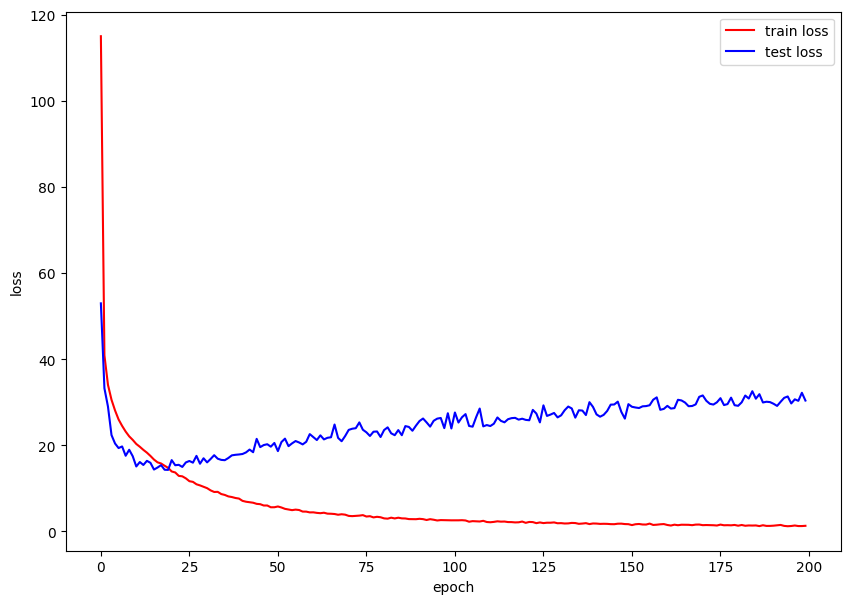

In [225]:
# 确保所有随机种子一致
torch.manual_seed(112)
random.seed(112)
np.random.seed(112)
torch.cuda.manual_seed(112)
torch.cuda.manual_seed_all(112)

# 实例化 ResNet18 模型（而不是函数）
resnet18_ = m.resnet18()  # 修正：实例化模型
net = MyResNet().to(device)  # 创建你的自定义 ResNet 模型并移到 GPU 上

# 调用 full_procedure 训练模型
trainloss, testloss = full_procedure(net, epochs=200, bs=128, lr=0.001, alpha=0.99, gamma=0, wd=0, tolerance=0.00001)

# 绘制损失曲线
plot_loss(trainloss, testloss)